# Investigate Delta serum-escape scores

After analyzing the first set of serum-escape data, I think that the ~5% of cells that I was sorting out were essentially all non-functional RBD variants that are being purged by the computational filters on RBD binding and expression.

I want to investigate the escape scores before I filter anything out.

## Set up analysis 

In [1]:
import os

from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

# import matplotlib.pyplot as plt

import math
import numpy as np

import pandas as pd

import plotnine
from plotnine import *

# import seaborn

import yaml

Set the theme

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")
print(f"Using pandas version {pd.__version__}")
print(f"Using plotnine version {plotnine.__version__}")

Using dms_variants version 0.8.10
Using pandas version 1.3.4
Using plotnine version 0.8.0


Define results directory

In [4]:
resultsdir = 'results/investigate_scores'
os.makedirs(resultsdir, exist_ok=True)

Read config file

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read in escape scores, only keep the relevant columns, and sort by escape score (descending).
I want to see what the highest scores are.

We can clearly tell from this plot [(escape score vs. variant_class)](https://github.com/jbloomlab/SARS-CoV-2-RBD_Delta/blob/main/results/summary/counts_to_scores_files/counts_to_scores_63_0.png) that multiple-mutants are more likely to have large escape scores -- this suggests that stability-mediated effects are dominating here. 

In [6]:
escape_scores = (pd.read_csv(config['escape_scores'])
                            [['name', 'library', 'barcode',
                              'score', 'pre_count', 'post_count',
                              'aa_substitutions', 'n_aa_substitutions', 'variant_class', 
                              'pre_count_filter_cutoff', 'pass_pre_count_filter',
                              'muts_pass_bind_filter', 'muts_pass_expr_filter',
                              'pass_ACE2bind_expr_filter']]
                           )

In [7]:
display(HTML(escape_scores
             .query('variant_class=="1 nonsynonymous" & pass_pre_count_filter')
             .sort_values(by=['score'], ascending=False)
             .rename(columns={'name': 'selection', 'aa_substitutions': 'mutation'})
             .drop(columns=['n_aa_substitutions','variant_class'])
             .assign(site=lambda x: x['mutation'].str[1: -1].astype(int) + config['site_number_offset'],
                     wildtype=lambda x: x['mutation'].str[0],
                     mutant=lambda x: x['mutation'].str[-1],
                     mutation=lambda x: x['wildtype']+x['site'].astype(str)+x['mutant']
                    )
             .head(5)
             .to_html(index=False)
            )
       )

selection,library,barcode,score,pre_count,post_count,mutation,pre_count_filter_cutoff,pass_pre_count_filter,muts_pass_bind_filter,muts_pass_expr_filter,pass_ACE2bind_expr_filter,site,wildtype,mutant
277C_repeat_500,lib2,TCCCTTTCATTTAAAT,1.0,202,261,R454N,116.0,True,False,False,False,454,R,N
279C_repeat_1250,lib2,AAGTCCCTGGTTTATG,1.0,311,474,Y495K,186.0,True,False,False,False,495,Y,K
279C_repeat_1250,lib2,CAACAAGAGATAGCCA,1.0,311,451,C379P,186.0,True,False,False,False,379,C,P
Delta_7_1250,lib2,TGAACGGCATCCCCCG,1.0,175,200,C379H,117.0,True,True,False,False,379,C,H
276C_repeat_500,lib1,GCAAGTTTCTTTTTTA,1.0,254,283,F400S,153.1,True,False,False,False,400,F,S


Can we make a correlation matrix to look at correlations of escape scores between samples (after filtering for min_counts but before filtering for bind and expr scores)

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12.0 x 6.0 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/investigate_scores/escape-corr-by-barcode.pdf
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12.0 x 12.0 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/investigate_scores/escape-corr-by-aa_substitutions.pdf


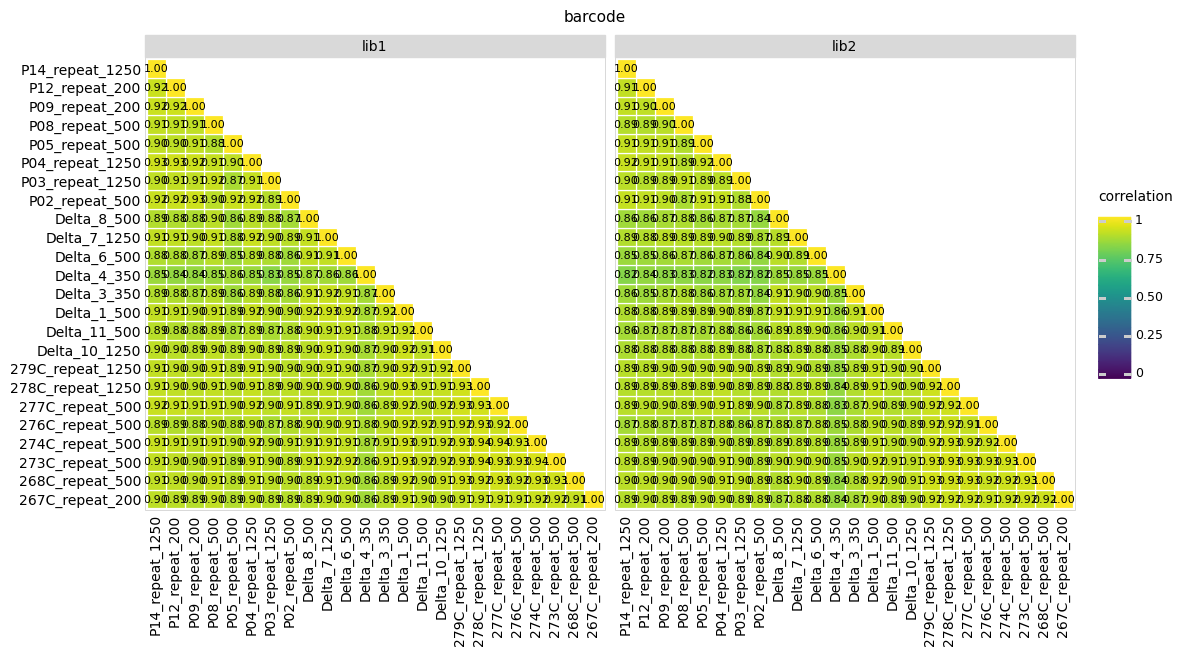

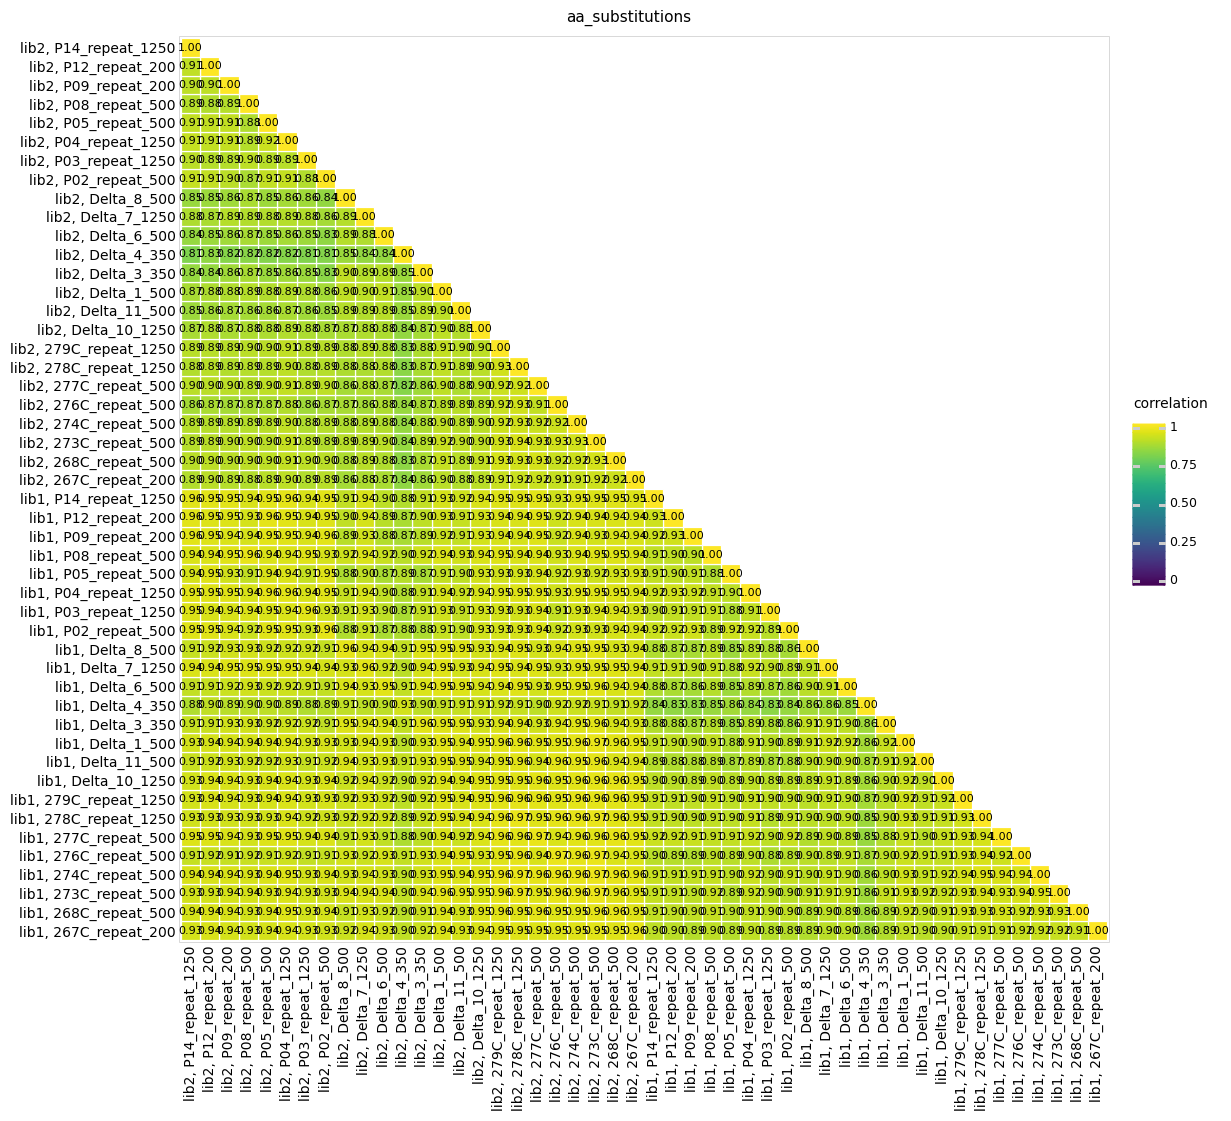

In [8]:
for score_by in ['barcode', 'aa_substitutions']:
    
    # get correlations
    if score_by=="barcode":
        corr = dms_variants.utils.tidy_to_corr(
                df=escape_scores
                   .query('pass_pre_count_filter')
                   .assign(sample=lambda x: (x['name'] if score_by == 'barcode'
                                             else x['library'] + ', ' + x['name'])
                           ),
                sample_col='sample',
                label_col=score_by,
                value_col='score',
                group_cols='library' if score_by == 'barcode' else None,
                method='pearson',
                )
    else:
        corr = dms_variants.utils.tidy_to_corr(
                df=(escape_scores
                    .query('pass_pre_count_filter')
                    .groupby(['name', score_by, 'library'])
                    .agg({'score': np.mean})
                    .reset_index()
                   .assign(sample=lambda x: (x['name'] if score_by == 'barcode'
                                             else x['library'] + ', ' + x['name'])
                           )),
                sample_col='sample',
                label_col=score_by,
                value_col='score',
                group_cols='library' if score_by == 'barcode' else None,
                method='pearson',
                )
    
    # plot the correlations
    if score_by == 'barcode':
        npanels = corr['library'].nunique()
    else:
        npanels = 1
    nsamples = corr['sample_1'].nunique()
    p = (
        ggplot(corr.query('sample_1 >= sample_2')
               .assign(corr_str=lambda x: x['correlation'].map('{:.2f}'.format),
                       sample_1=lambda x: pd.Categorical(x['sample_1'],
                                                         reversed(x['sample_1'].unique()),
                                                         ordered=True)
                       ), 
               aes('sample_1', 'sample_2',
                   fill='correlation', label='corr_str')) +
        geom_tile(color='white', size=0.5) +
        geom_text(size=8) +
        labs(title=score_by) +
        theme(figure_size=(0.25 * nsamples * npanels, 0.25 * nsamples),
              panel_grid_major=element_blank(),
              axis_text_x=element_text(angle=90),
              plot_title=element_text(size=11),
              ) +
        scale_fill_continuous(limits=(0, 1)) +
        xlab('') +
        ylab('')
        )
    if score_by == 'barcode' and corr['library'].nunique() > 1:
        p = p + facet_wrap('~ library', nrow=1)
    _ = p.draw()
    p.save(f'{resultsdir}/escape-corr-by-{score_by}.pdf', limitsize=False)

Read in DMS ACE2 binding and RBD expression scores

In [9]:
dms_scores = pd.read_csv(config['final_variant_scores_mut_file'])

In [10]:
scores= (escape_scores
        .query('variant_class=="1 nonsynonymous" & pass_pre_count_filter')
        .rename(columns={'name': 'selection', 'aa_substitutions': 'mutation'})
        .drop(columns=['n_aa_substitutions','variant_class', 'pre_count', 'post_count', 'pre_count_filter_cutoff'])
        .assign(site=lambda x: x['mutation'].str[1: -1].astype(int) + config['site_number_offset'],
                wildtype=lambda x: x['mutation'].str[0], 
                mutant=lambda x: x['mutation'].str[-1],
                mutation=lambda x: x['wildtype']+x['site'].astype(str)+x['mutant']
               )
        .merge(dms_scores[['mutation', 'delta_bind', 'delta_expr']],
               how='left',
               on='mutation',
               validate='many_to_one'
              )
       )

display(HTML(scores.head().to_html(index=False)))

selection,library,barcode,score,mutation,pass_pre_count_filter,muts_pass_bind_filter,muts_pass_expr_filter,pass_ACE2bind_expr_filter,site,wildtype,mutant,delta_bind,delta_expr
267C_repeat_200,lib1,GCTACAAAGTCCGCAG,0.828400,D398T,True,True,False,False,398,D,T,-0.91858,-2.61807
267C_repeat_200,lib1,ATCGAAATTGAGTGAT,0.300400,F429I,True,True,False,False,429,F,I,-0.56820,-2.10913
267C_repeat_200,lib1,TGATGATTCCTAAGAA,0.086770,P463K,True,True,False,False,463,P,K,-0.51220,-1.62825
267C_repeat_200,lib1,TTAAAGTAGTACGACA,0.010500,P337T,True,True,True,True,337,P,T,-0.09541,-0.24318
267C_repeat_200,lib1,ACGTGAAACACCATGT,0.001187,S349Q,True,True,True,True,349,S,Q,-0.53301,-0.57184


Plot relationship between bind and expr scores and serum escape scores for each selection:

/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 12 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/investigate_scores/escape-vs-bind.pdf
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 12 in image.
/fh/fast/bloom_j/computational_notebooks/agreaney/2021/SARS-CoV-2-RBD_Delta/env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: results/investigate_scores/escape-vs-expr.pdf


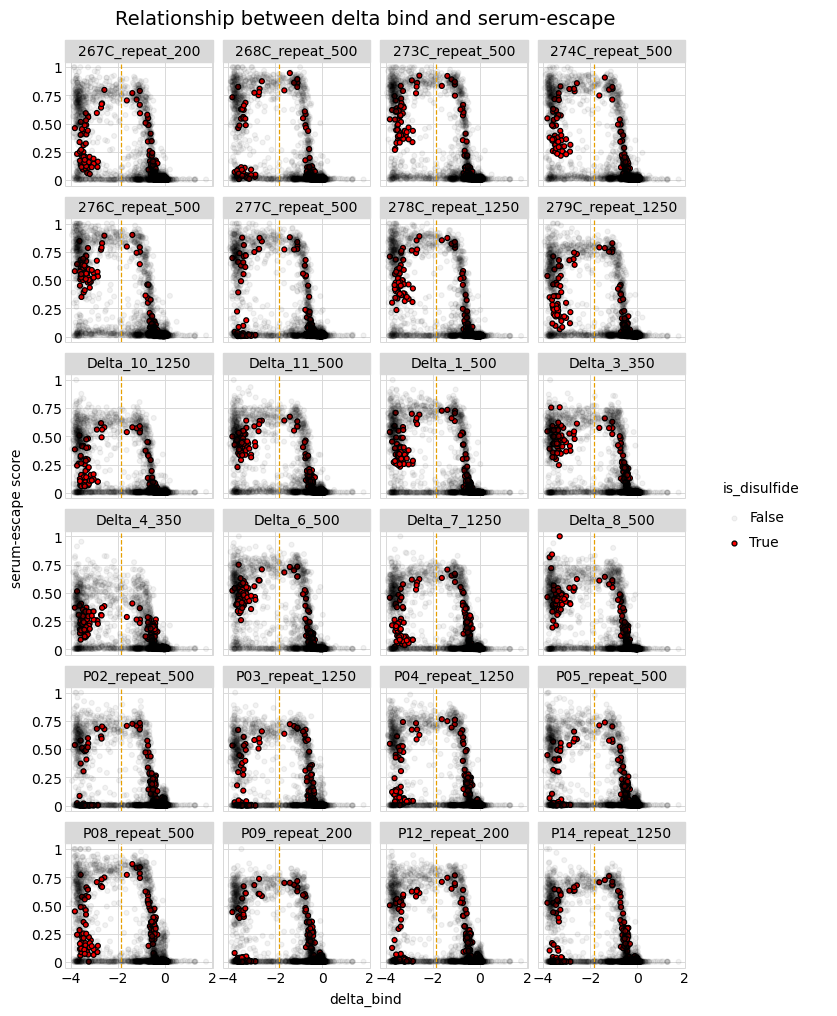

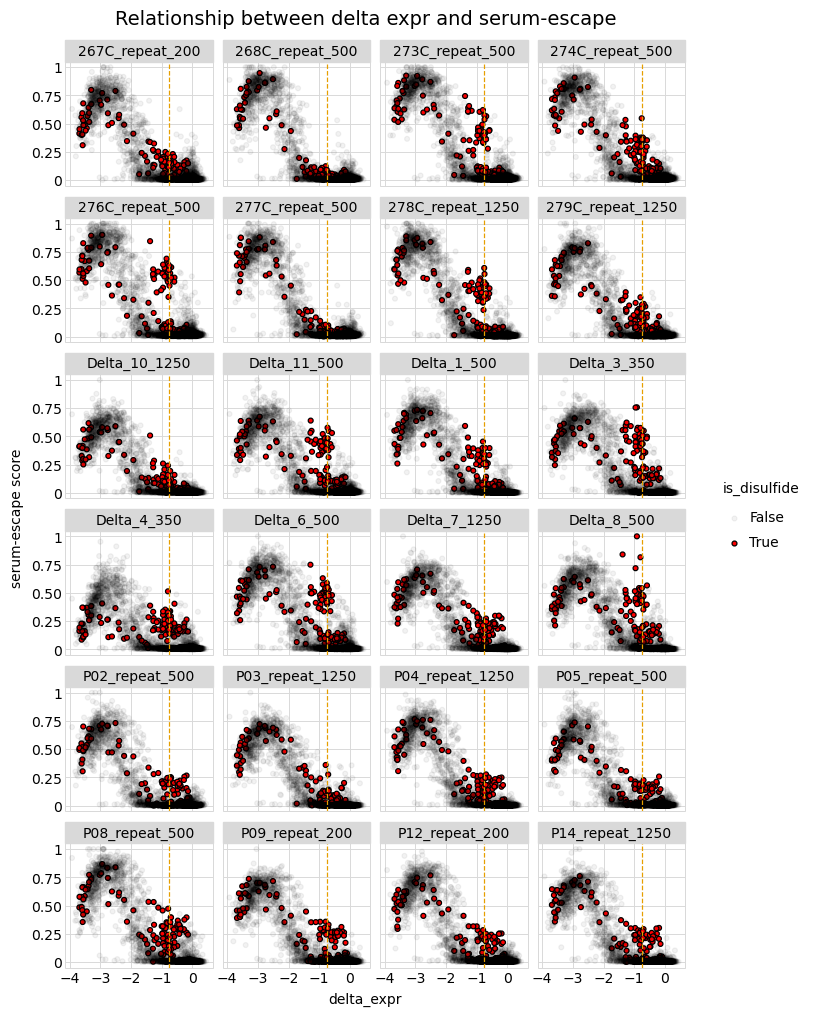

In [11]:
for metric in ['bind', 'expr']:

    nfacets = scores['selection'].nunique()
    ncol = min(nfacets, 4)
    nrow = math.ceil(nfacets / ncol)
    xmin = scores[f'delta_{metric}'].min()
    xspan = scores[f'delta_{metric}'].max() - xmin
    ymin = scores['score'].min()
    yspan = scores['score'].max() - ymin
    p = (ggplot(scores
                .assign(is_disulfide=lambda x: x['mutation'].apply(lambda s: s[0]).isin(["C"]))
                .groupby(['selection', 'mutation', 'delta_bind', 'delta_expr', 'is_disulfide'])
                .agg({'score': np.mean})
                .rename(columns={'score':'serum-escape score'})
                .reset_index()
               ) +
         aes(x=f'delta_{metric}', y='serum-escape score', fill='is_disulfide', alpha='is_disulfide') +
         geom_point() +
         geom_vline(xintercept=config[f'escape_score_min_{metric}_mut'], 
                linetype='dashed',
                color=CBPALETTE[1]) +
         facet_wrap('~ selection', ncol=ncol) +
         theme(figure_size=(2 * ncol, 2 * nrow),
               plot_title=element_text(size=14),
              ) +
         ggtitle(f'Relationship between delta {metric} and serum-escape') +
         scale_fill_manual(values=['black', 'red']) +
         scale_alpha_manual(values=[0.05,1])
         )

    _ = p.draw()
    
    p.save(f'{resultsdir}/escape-vs-{metric}.pdf', limitsize=False)

## Thoughts / Conclusions:

The correlations are very high at the barcode and amino-acid level among all the sera.

The serum-escape scores have a strong relationship with RBD expression score.

My conclusion from all this is that I was indeed very cleanly sorting out highly deleterious mutants that were well-folded and ACE2-binding enough to get through my RBD+/ACE2+ pre-sort (incubating with 1e-8M dimeric ACE2, gating on WT incuabted with 1e-10M dimeric ACE2).